# Machine Learning Project

## Binary classification based on 3 layers neural network (2)

#### First layer

$Z^{[1]} = W^{[1]} X + b^{[1]}$ : $X$ denotes the input data

$A^{[1]} = g^{[1]}(Z^{[1]})$ : $g^{[1]}$ is the activation function at the first layer

#### Second layer

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$

$A^{[2]} = g^{[2]}(Z^{[2]})$ : $g^{[2]}$ is the activation function at the second layer

#### Third layer

$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$

$A^{[3]} = g^{[3]}(Z^{[3]})$ : $g^{[3]}$ is the activation function at the third (output) layer

### Activation Function

- Sigmoid

    $g(z) = \frac{1}{1 + \exp^{-z}}$

- tanh

    $g(z) = \frac{\exp^{z} - \exp^{-z}}{\exp^{z} + \exp^{-z}}$

- ReLU

    $g(z) = \max(0, z)$

- Leaky ReLU

    $g(z) = \max(\alpha z, z), \quad \alpha \in \mathbb{R}^+$

### Neural Network Architecture

- The sizes of the hidden layers and the output layer should be determined with respect to the validation accuracy obtained by the network architecture with all the activation functions being sigmoid functions. ($g^{[1]} = g^{[2]} = g^{[3]} =$ Sigmoid)
- Apply different activation functions at all the layers except the output layer that should be Sigmoid function
- Apply different activation functions at different layers except the output layer that should be Sigmoid function

### Dataset

- The dataset consists of human images and horse images for the training and the validation
- The classifier should be trained using the training set
- The classifier should be tested using the validation set
- Vectorize an input image matrix into a column vector

### Implementation

- Write codes in python programming
- Use jupyter notebook for the programming environment
- You can use any libarary
- You have to write your own functions for the followings:
    - compute the forward propagation
    - compute the backward propagation
    - compute the loss
    - compute the accuracy
    - compute the gradient of the model parameters with respect to the loss
    - update the model parameters
    - plot the results

### Optimization

- Apply the gradient descent algorithm with an appropriate learning rate
- Apply the number of iterations that lead to the convergence of the algorith
- Use the vectorization scheme in the computation of gradients and the update of the model parameters

### [ Implementation ]

#### (1) Libraries and Global variables

In [155]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import math
import os

# Global Variables
train_data_path = './horse-or-human/train'
validation_data_path = './horse-or-human/validation'

layer_dims = [10000,50,10,1]    # number of units(Neurons) in each layer
learning_rate = 0.02            # step size per each epoch (iteration)
threshold = 0.1                 # minimum of cost
max_epoch = 2500                # maximum number of epoch (iteration)

#### (2) Generate Input matrix X and Output vector Y from training and validation datasets

In [156]:
def initialize_inputs(image_path) :
    transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),])
    # the code transforms.Grayscale() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
    image_set = torchvision.datasets.ImageFolder(root=image_path, transform=transform)
    loader = torch.utils.data.DataLoader(image_set, batch_size=1, shuffle=False, num_workers=1)  

    for i,data in enumerate(loader) :
        image, label = data
        image = image.view(10000,1)
        label = label.view(1,1).type(torch.FloatTensor)
        
        if i == 0 :
            t_images = image
            t_labels = label
        else :
            t_images = torch.cat((t_images,image),dim = 1)
            t_labels = torch.cat((t_labels,label),dim = 1)
        
        images = t_images.numpy()
        labels = t_labels.numpy()
    
    return images, labels

#### (3) Activation Functions

In [158]:
def Sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def Sigmoid_backward(dA, Z):
    t_A = 1/(1+np.exp(-Z))
    dZ = dA * t_A * (1-t_A)
    return dZ

def ReLU(Z):
    A = np.maximum(0,Z)
    return A

def ReLU_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0    
    return dZ

def Leaky_ReLU(Z) :
    A = np.maximum(0.1*Z, Z)
    return A

def Leaky_ReLU_backward(dA,Z) :
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0.1
    return dZ
    
def Tanh(Z) :
    exp_Z, exp_nZ = np.exp(Z), np.exp(-Z)    
    A = np.divide(exp_Z - exp_nZ, exp_Z + exp_nZ)
    return A

def Tanh_backward(dA, Z) :
    exp_Z, exp_nZ = np.exp(Z), np.exp(-Z)    
    t_A = np.divide(exp_Z - exp_nZ, exp_Z + exp_nZ)
    dZ = 1 - np.square(t_A)
    return dZ

#### (4) Cost and Parameter initialization / update Functions

In [159]:
def initalize_parameters(n) :
    parameters = dict()
    
    # Initalize W[i] and b[i] for i in [1,L-1]
    for l in range(1,len(n)) :
        parameters['W'+str(l)] = np.random.randn(n[l],n[l-1]) / np.sqrt(n[l-1])
        parameters['b'+str(l)] = np.zeros((n[l],1))
        
    return parameters

def update_parameters(parameters,gradients,learning_rate) :
    L = len(parameters) // 2
    
    # Update W[i] and b[i] for i in [1,L]
    for l in range(1,L+1) :
        dW, db = gradients['dW'+str(l)], gradients['db'+str(l)]
        parameters['W'+str(l)] -= learning_rate * dW
        parameters['b'+str(l)] -= learning_rate * db

    return parameters

def cost_computation(AL, Y) :
    m = Y.shape[1]
    
    cost = (-np.dot(Y,np.log(AL).T) - np.dot(1-Y,np.log(1-AL).T)) / m
    cost = np.squeeze(cost)
    return cost

#### (5) Forward Propagation

In [203]:
def forward_Z_computation(A_prev,W,b) :
    Z = np.dot(W,A_prev) + b
    return Z

def forward_A_computation(A_prev,W,b,activation) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    
    Z = forward_Z_computation(A_prev,W,b)
    if activation == 'sigmoid' :
        A = Sigmoid(Z)
    elif activation == 'relu' :
        A = ReLU(Z)
    elif activation == 'tanh' :
        A = Tanh(Z)
    else :
        A = Leaky_ReLU(Z)
    
    cache = ((A_prev,W,b),Z)
    return A, cache

def forward_propagation(X,parameters,activations) :
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L+1) :
        A_prev, W, b = A, parameters['W'+str(l)], parameters['b'+str(l)]
        A,cache = forward_A_computation(A_prev,W,b,activations[l-1])
        caches.append(cache)    
    AL = A
    
    return AL, caches

#### (6) Backward Propagation

In [204]:
def backward_params_dev_computation(dZ, cache) :
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ,a_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def backward_params_dev_computation(dA,cache,activation) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    (A_prev,W,b),Z = cache
    m = A_prev.shape[1]

    if activation == 'sigmoid' :
        dZ = Sigmoid_backward(dA,Z)
    elif activation == 'relu' :
        dZ = ReLU_backward(dA,Z)
    elif activation == 'tanh' :
        dZ = Tanh_backward(dA,Z)
    else :
        dZ = Leaky_ReLU_backward(dA,Z)
    
    dW = np.dot(dZ,A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def backward_propagation(AL, Y, caches,activations) :
    gradients = dict()
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y,AL) - np.divide(1-Y,1-AL))
    cache = caches[L-1]
    dA_prev, dW, db = backward_params_dev_computation(dAL,cache,activations[L-1])
    gradients['dA'+str(L)] = dA_prev
    gradients['dW'+str(L)] = dW
    gradients['db'+str(L)] = db
    
    for l in reversed(range(1,L)) :
        dA = gradients['dA' + str(l+1)]
        dA_prev, dW, db = backward_params_dev_computation(dA,caches[l-1],activations[l-1])
        gradients['dA'+str(l)] = dA_prev
        gradients['dW'+str(l)] = dW
        gradients['db'+str(l)] = db
        
    return gradients

#### (7) Predictions

In [205]:
def predict(X, Y, parameters,activations) :
    
    AL, _t = forward_propagation(X,parameters,activations)
    correct = np.zeros(Y.shape)
    m = AL.shape[1]

    prediction = AL > 0.5
    correct = prediction == Y
    
    accuracy = np.sum(correct) / m * 100
    return accuracy

#### (8) 3-layer Neural Network

In [206]:
def NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch) :
    costs = []
    np.random.seed(1)
    parameters = initalize_parameters(n)
    
    
    for epoch in range(max_epoch) :
        AL, caches = forward_propagation(X, parameters, activations)
        cost = cost_computation(AL, Y)
        gradients = backward_propagation(AL, Y, caches,activations)
        parameters = update_parameters(parameters,gradients,learning_rate)
        costs.append(cost)
        if  epoch % 100 == 0:
            print ("Cost after iteration %i: %f" %(epoch, cost))
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters    

### Output

- Plot the training loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the validation loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the training accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Plot the validation accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Present the table for the final accuracy and loss with training and validation datasets with your best neural network architecture as below:

##### $g^{[1]}, g^{[2]}, g^{[3]}$ are Sigmoid (from the previous assignment)

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

##### $g^{[1]}, g^{[2]}$ are tanh and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

##### $g^{[1]}, g^{[2]}$ are ReLU and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table 

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

##### $g^{[1]}, g^{[2]}$ are Leaky ReLU with your choice of $\alpha$ and $g^{[3]}$ is Sigmoid

- Learning curves
- Loss and Accuracy table

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |


In [171]:
X,Y = initialize_inputs(train_data_path)
t_X, t_Y = initialize_inputs(validation_data_path)

Cost after iteration 0: 0.693070
Cost after iteration 100: 0.692731
Cost after iteration 200: 0.692351
Cost after iteration 300: 0.691433
Cost after iteration 400: 0.688546
Cost after iteration 500: 0.681569
Cost after iteration 600: 0.660383
Cost after iteration 700: 0.592398
Cost after iteration 800: 0.521480
Cost after iteration 900: 0.510647
Cost after iteration 1000: 0.479628
Cost after iteration 1100: 0.445933
Cost after iteration 1200: 0.427579
Cost after iteration 1300: 0.399542
Cost after iteration 1400: 0.389146
Cost after iteration 1500: 0.315435
Cost after iteration 1600: 0.301490
Cost after iteration 1700: 0.292873
Cost after iteration 1800: 0.204070
Cost after iteration 1900: 0.265831
Cost after iteration 2000: 0.161515
Cost after iteration 2100: 0.134234
Cost after iteration 2200: 0.157663
Cost after iteration 2300: 0.091543
Cost after iteration 2400: 0.077233


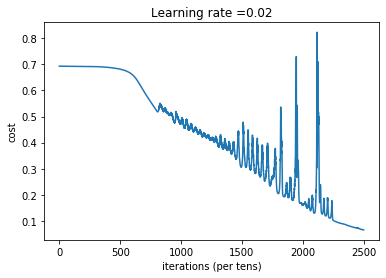

In [207]:
n = [10000,50,10,1]
activations = ['relu','relu','sigmoid']
learning_rate = 0.02
thres_hold = 0.1
max_epoch = 2500

parameters = NN_3_layers(X,Y,t_X,t_Y,n,activations,learning_rate,threshold,max_epoch)

In [208]:
accuracy = predict(X, Y, parameters,activations)
print(accuracy)

99.80525803310614
